In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss, precision_recall_fscore_support, classification_report, accuracy_score, f1_score, precision_score, recall_score)
from tabulate import tabulate

# Utility
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time
import matplotlib.image as mpimg
from IPython.display import Image, display
from IPython.core.display import HTML
from sklearn.exceptions import ConvergenceWarning

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Ignorare avvisi
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", ConvergenceWarning)

In [3]:
def plot_class_distribution(df, column_name, title='Distribuzione delle Classi', color='navy', ax=None):
    # Impostazioni estetiche per il grafico
    sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

    # Creazione del grafico
    if ax is None:
        ax = plt.gca()  # Se non viene passato un asse, usa quello corrente
    sns.countplot(x=column_name, data=df, color=color, ax=ax)  # Imposta un colore uniforme per le barre

    # Titolo e etichette
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Classi', fontsize=14)
    ax.set_ylabel('Numero di Occorrenze', fontsize=14)

    # Aggiungere il numero sopra ogni barra con lo stesso colore della barra
    for p in ax.patches:
        height = int(p.get_height())  # Otteniamo l'altezza della barra
        ax.annotate(f'{height}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, 
                    color=p.get_facecolor(),  # Impostiamo il colore del testo uguale a quello della barra
                    xytext=(0, 5), textcoords='offset points')

In [4]:
# Caricamento Dataset
data = pd.read_csv("/Users/diego/Desktop/dataset_ottimizzato.csv")

In [5]:
data.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas lineage l...


In [6]:
# Separazione delle feature e del target
X = data[['Gene', 'Variation', 'text']]  # Feature
y = data['Class']  # Target

In [7]:
# One Hot Encoding per Gene e Variation
one_hot_encoder = OneHotEncoder()

# Applica One Hot Encoding su Gene e Variation
X_gene_variation = one_hot_encoder.fit_transform(X[['Gene', 'Variation']]).toarray() 

In [8]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Limita il numero di feature
X_text_tfidf = tfidf.fit_transform(X['text']) 

# SVD
svd = TruncatedSVD(n_components=300, random_state=42)  # Riduci a 300 dimensioni
X_text_svd = svd.fit_transform(X_text_tfidf)

#SCALER
scaler = StandardScaler()
X_text_scaled = scaler.fit_transform(X_text_svd) 


In [9]:
# Concatena le feature (Gene, Variation) con quelle testuali
X_final = np.hstack([X_gene_variation, X_text_scaled])

In [10]:
# Definisci la strategia di oversampling con SMOTE
oversampler = SMOTE(sampling_strategy={3: 300, 5: 300, 8: 300, 9: 300})

# Applica SMOTE per bilanciare i dati
X_balanced, y_balanced = oversampler.fit_resample(X_final, y)

# Divisione in train e test set
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

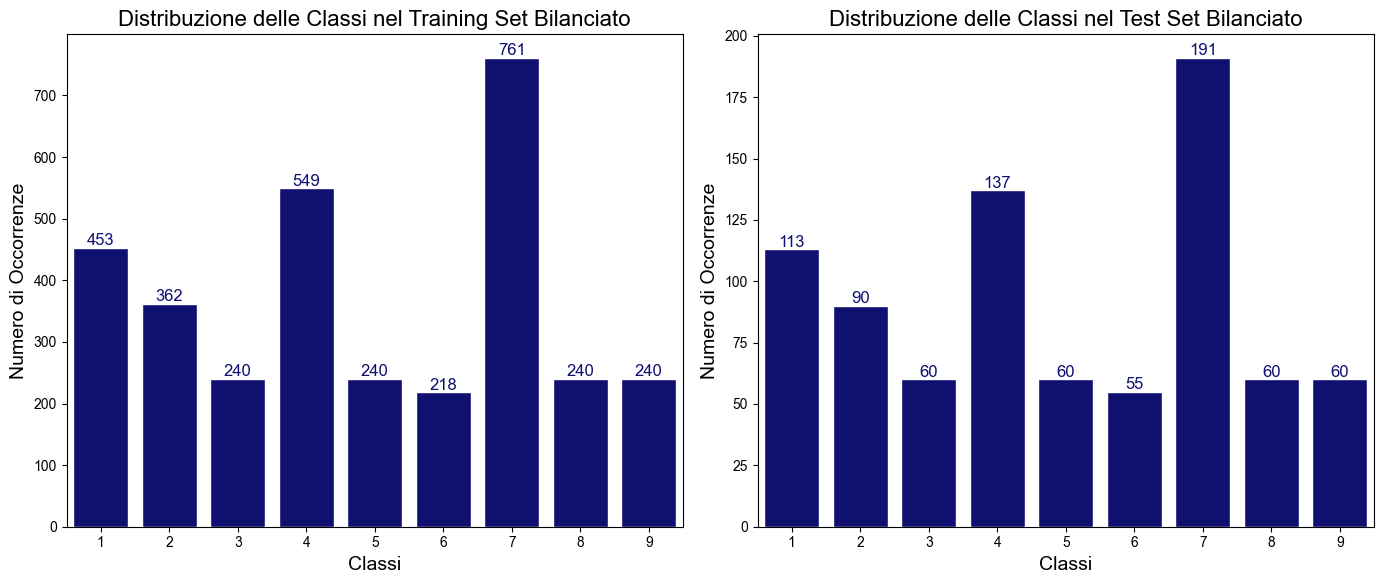

In [11]:
# Visualizza la distribuzione delle classi nel training e nel test set
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grafico per il training set
plot_class_distribution(df=pd.DataFrame({'Class': y_train}), column_name='Class', title='Distribuzione delle Classi nel Training Set Bilanciato', color='navy', ax=axes[0])

# Grafico per il test set
plot_class_distribution(df=pd.DataFrame({'Class': y_test}), column_name='Class', title='Distribuzione delle Classi nel Test Set Bilanciato', color='navy', ax=axes[1])

# Ottimizzazione della disposizione dell'intero layout
plt.tight_layout()
plt.show()

In [12]:
# Definizione dei parametri da ottimizzare
param_grid = {
    'n_estimators': [100, 250, 400],
    'max_depth': [30, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}

# Creazione del modello con n_jobs=-1 per utilizzare tutte le CPU
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grid Search con scoring basato sull'F1-score
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Miglior modello e parametri
best_rf = grid_search.best_estimator_
print("Migliori parametri trovati:", grid_search.best_params_)

# Predizione con il miglior modello
y_pred = best_rf.predict(X_test)

# Valutazione del modello
print("Report di classificazione:")
print(classification_report(y_test, y_pred))

Migliori parametri trovati: {'class_weight': None, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 400}
Report di classificazione:
              precision    recall  f1-score   support

           1       0.65      0.58      0.61       113
           2       0.65      0.44      0.53        90
           3       0.79      0.82      0.80        60
           4       0.72      0.79      0.75       137
           5       0.61      0.68      0.65        60
           6       0.94      0.62      0.75        55
           7       0.67      0.80      0.73       191
           8       0.98      0.98      0.98        60
           9       1.00      1.00      1.00        60

    accuracy                           0.74       826
   macro avg       0.78      0.75      0.76       826
weighted avg       0.74      0.74      0.73       826

